<a href="https://colab.research.google.com/github/jackiekuen2/coursera-tensorflow/blob/master/Course_4_Week_4_Exercise_Melbourne_Temperature_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install tensorflow==2.0.0b1
!pip install tensorflow-gpu==2.0.0-rc1

     |████████████████████████████████| 380.5MB 52kB/s 
     |████████████████████████████████| 4.3MB 53.9MB/s 
     |████████████████████████████████| 501kB 50.5MB/s 


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.0.0-rc1


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2019-09-15 17:29:34--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.001s  

2019-09-15 17:29:34 (56.6 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



In [ ]:
import pandas as pd

data = pd.read_csv('/tmp/daily-min-temperatures.csv')

In [ ]:
data.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


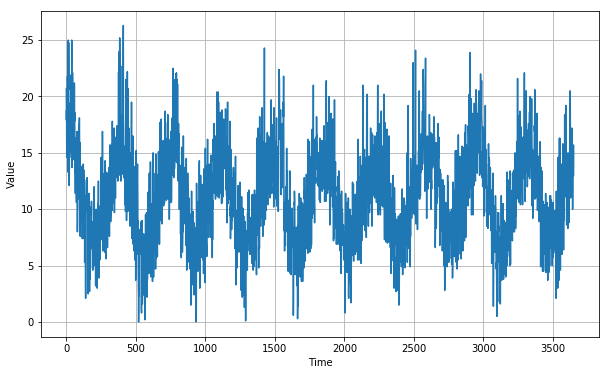

In [ ]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)

    step = 0
    for row in reader:
        temps.append(float(row[1]))
        time_step.append(step)
        step += 1

# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
len(temps)

3650

In [ ]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # YOUR CODE HERE
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [ ]:
def model_forecast(model, series, window_size):
    # YOUR CODE HERE
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
    # YOUR CODE HERE
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, 
                           padding="causal", activation="relu", 
                           input_shape=[None, 1]),
  	tf.keras.layers.LSTM(64, return_sequences=True),
	tf.keras.layers.LSTM(64, return_sequences=True),
  	tf.keras.layers.Dense(30, activation="relu"),
  	tf.keras.layers.Dense(10, activation="relu"),
  	tf.keras.layers.Dense(1),
  	tf.keras.layers.Lambda(lambda x: x * 100) 
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 7s 583ms/step - loss: 15.9590 - mae: 16.4412
Epoch 2/100
12/12 [==============================] - 0s 38ms/step - loss: 15.8604 - mae: 16.3933
Epoch 3/100
12/12 [==============================] - 0s 39ms/step - loss: 15.8135 - mae: 16.3225
Epoch 4/100
12/12 [==============================] - 0s 39ms/step - loss: 15.7173 - mae: 16.2379
Epoch 5/100
12/12 [==============================] - 0s 38ms/step - loss: 15.5976 - mae: 16.1403
Epoch 6/100
12/12 [==============================] - 0s 37ms/step - loss: 15.5064 - mae: 16.0286
Epoch 7/100
12/12 [==============================] - 0s 41ms/step - loss: 15.3481 - mae: 15.9009
Epoch 8/100
12/12 [==============================] - 0s 40ms/step - loss: 15.2352 - mae: 15.7538
Epoch 9/100
12/12 [==============================] - 0s 39ms/step - loss: 15.0692 - mae: 15.5830
Epoch 10/100
12/12 [==========

[1e-08, 0.0001, 0, 60]

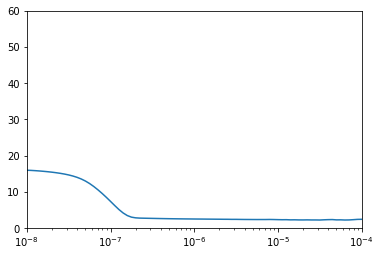

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
    # YOUR CODE HERE
    tf.keras.layers.Conv1D(filters=60, kernel_size=5, strides=1, 
                           padding="causal", activation="relu", 
                           input_shape=[None, 1]),
  	tf.keras.layers.LSTM(64, return_sequences=True),
	tf.keras.layers.LSTM(64, return_sequences=True),
  	tf.keras.layers.Dense(30, activation="relu"),
  	tf.keras.layers.Dense(10, activation="relu"),
  	tf.keras.layers.Dense(1),
  	tf.keras.layers.Lambda(lambda x: x * 400) 
])


optimizer = tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set,epochs=200, verbose=1)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/200
30/30 [==============================] - 5s 179ms/step - loss: 8.1173 - mae: 8.6835
Epoch 2/200
30/30 [==============================] - 1s 20ms/step - loss: 3.8447 - mae: 4.3144
Epoch 3/200
30/30 [==============================] - 1s 20ms/step - loss: 3.5612 - mae: 4.0296
Epoch 4/200
30/30 [==============================] - 1s 19ms/step - loss: 3.4885 - mae: 3.9556
Epoch 5/200
30/30 [==============================] - 1s 20ms/step - loss: 3.4145 - mae: 3.8847
Epoch 6/200
30/30 [==============================] - 1s 20ms/step - loss: 3.3641 - mae: 3.8357
Epoch 7/200
30/30 [==============================] - 1s 21ms/step - loss: 3.3164 - mae: 3.7848
Epoch 8/200
30/30 [==============================] - 1s 21ms/step - loss: 3.2657 - mae: 3.7365
Epoch 9/200
30/30 [==============================] - 1s 20ms/step - loss: 3.2309 - mae: 3.7047
Epoch 10/200
30/30 [==============================

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [ ]:
len(rnn_forecast)

650

In [ ]:
len(time_valid)

650

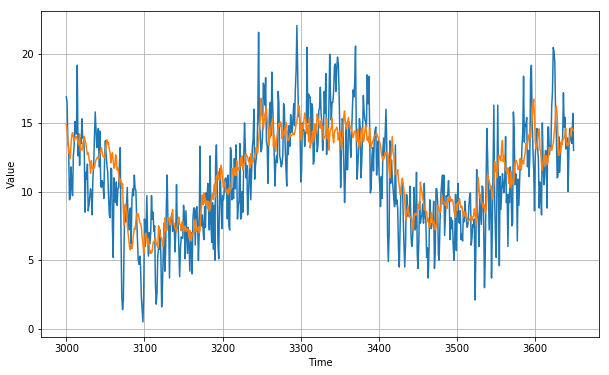

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

2.078116

In [ ]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[14.904907  14.456481  13.5971155 12.805793  12.934578  12.388223
 13.377532  14.126074  14.294016  13.987512  13.67751   13.880626
 14.038142  13.925788  13.861376  13.579411  13.393569  14.174602
 12.94936   13.088572  13.033157  13.476136  13.692578  14.013063
 13.730296  13.50072   13.055956  12.69674   12.827248  12.38276
 12.097766  11.317561  12.248464  11.76916   11.5874405 11.801101
 11.710097  12.088184  12.3084345 12.394803  12.519344  12.407739
 12.398397  12.832936  12.952328  13.19071   12.790012  12.553772
 12.539095  12.464785  12.869271  13.411641  13.775399  13.457635
 13.592783  13.061964  12.829987  12.0951185 12.615344  12.834367
 12.218021  11.70132   11.771847  12.678707  12.4591675 11.570885
 11.723644  11.229694  10.671965  10.920765  10.783798  10.235679
 10.583631   8.64619    7.5939975  9.04688    9.071436   8.522416
  7.6197257  6.9778004  6.438745   5.9165635  5.760456   6.130003
  5.8559127  6.274193   6.8925014  7.326228   7.2380075  7.8834944
  8.389985